## Business Goal:  Identify which customer regions generate the highest total sales for each product category, month-by-month.

### Set up the notebook

In [202]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
from dash import Dash, dcc, html, Input, Output

### Connect to the SQLite Database

In [203]:
conn = sqlite3.connect(r"C:\Users\beths\Documents\Northwest_Missouri_Analytics\BI_Analytics\smart-store-bethspornitz\data\dw\smart_sales.db")

### Preview Tables

In [204]:
# Check table names
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

       name
0  customer
1   product
2      sale


### OLAP Query  
This query joins the three tables and aggregates total sales by region, category, and month:

In [205]:
query = """
SELECT 
    c.customer_region AS customer_region,
    p.product_category AS product_category,
    strftime('%Y-%m', s.purchase_date) AS sale_month,
    SUM(s.sale_amount_usd) AS total_sales
FROM sale s
JOIN customer c ON s.customer_id = c.customer_id
JOIN product p ON s.product_id = p.product_id
GROUP BY customer_region, product_category, sale_month
ORDER BY customer_region, product_category, sale_month;
"""
df_olap = pd.read_sql(query, conn)


### Create a separate aggregated DataFrame

In [215]:
df_line_chart = (
    df_olap.groupby(["customer_region", "sale_month"], as_index=False)
    .agg(total_sales=("total_sales", "sum"))
)

Preview Results

In [207]:
df_olap.head()

,customer_region,product_category,sale_month,total_sales
0,East,Clothing,2024-02,1318.10
1,East,Clothing,2024-05,117.30
2,East,Clothing,2024-06,387.90
3,East,Clothing,2024-07,694.34
4,East,Clothing,2024-08,1263.90


Pivot Table

In [216]:
pivot_df = df_olap.pivot_table(
    index="customer_region",
    columns="product_category",
    values="total_sales",
    aggfunc="sum",
    fill_value=0
)
pivot_df

product_category,Clothing,Electronics,Sports
customer_region,,,
East,4083.24,58400.28,276.92
North,3544.42,1690.62,336.26
South,3387.34,20711.52,39.56
West,2370.78,13656.52,19.78


Bar Plot: Total Sales by Region and Product Category


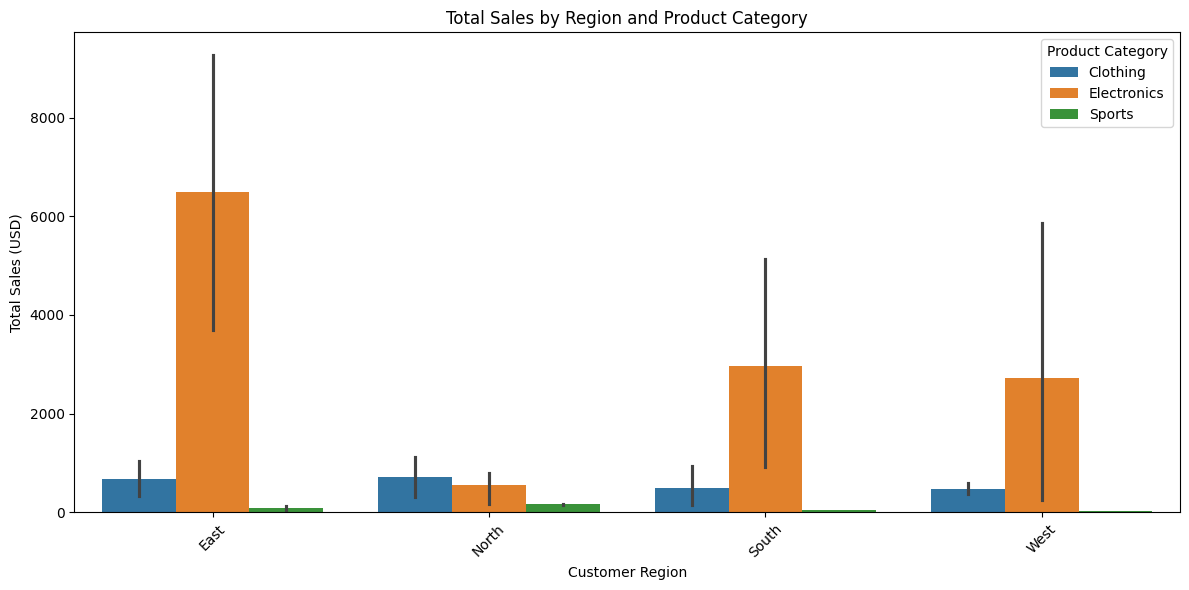

In [208]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_olap, x="customer_region", y="total_sales", hue="product_category")
plt.title("Total Sales by Region and Product Category")
plt.ylabel("Total Sales (USD)")
plt.xlabel("Customer Region")
plt.legend(title="Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Line Chart: Sales Trends by Month (Faceted by Region)

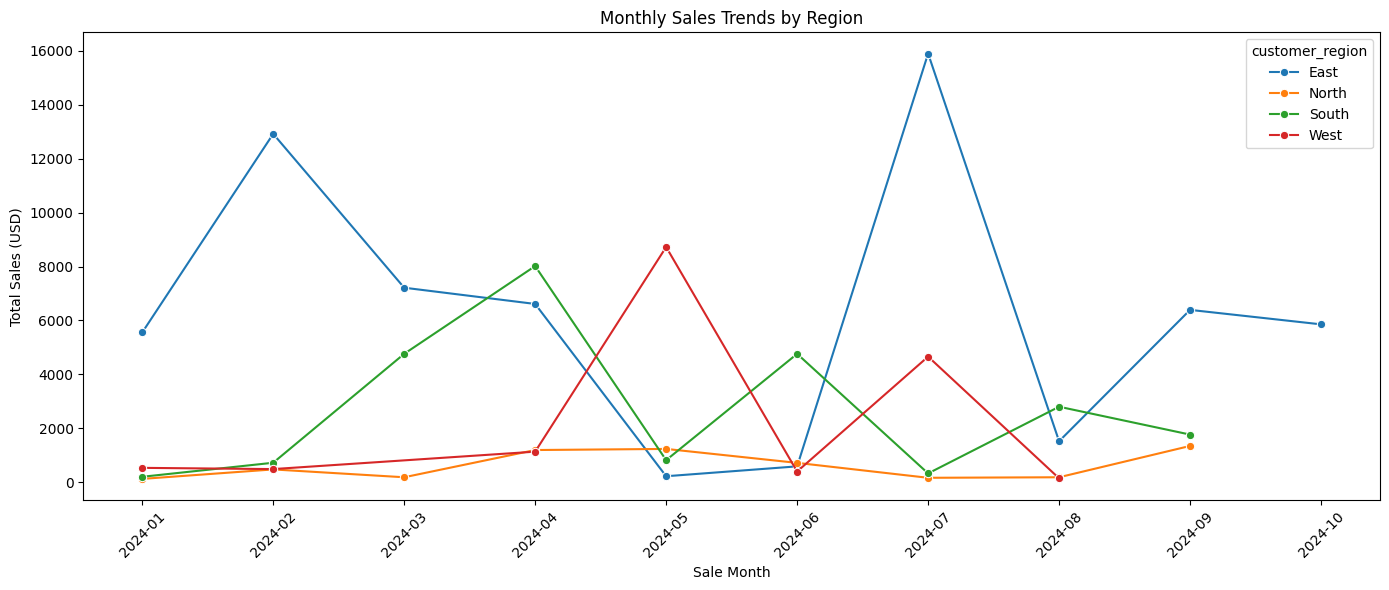

In [209]:
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=df_line_chart,
    x="sale_month",
    y="total_sales",
    hue="customer_region",
    marker="o"
)
plt.title("Monthly Sales Trends by Region")
plt.xticks(rotation=45)
plt.ylabel("Total Sales (USD)")
plt.xlabel("Sale Month")
plt.tight_layout()
plt.show()

Heatmap: Region vs Product Category by Total Sales

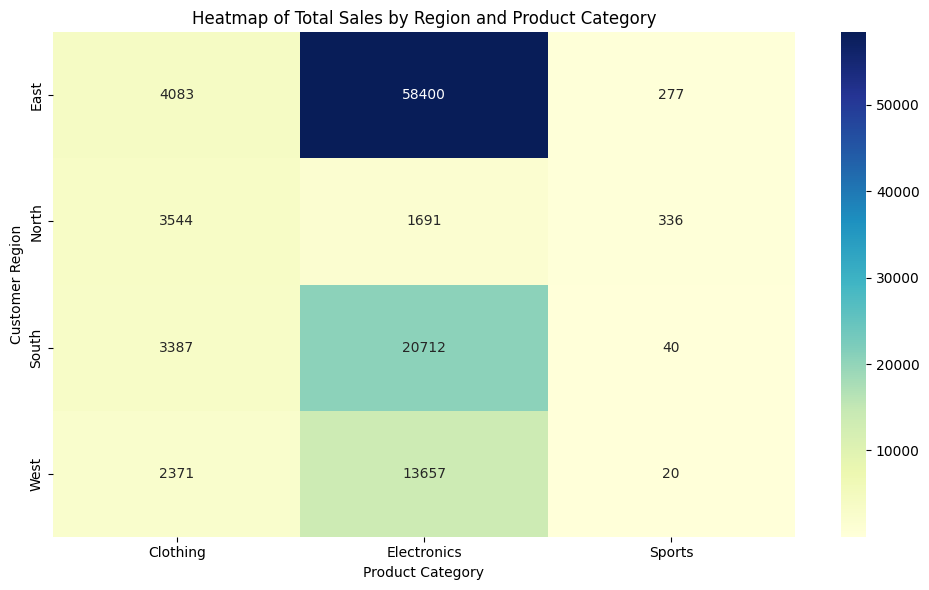

In [210]:
heatmap_data = df_olap.pivot_table(
    index="customer_region", 
    columns="product_category", 
    values="total_sales", 
    aggfunc="sum", 
    fill_value=0
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Heatmap of Total Sales by Region and Product Category")
plt.ylabel("Customer Region")
plt.xlabel("Product Category")
plt.tight_layout()
plt.show()

Interactive Bar Chart: Total Sales by Region and Product Category

In [211]:


# Create Dash app
app = Dash(__name__)

# Layout
app.layout = html.Div([
    html.H1(
        "Total Sales by Region and Product Category",
        style={
            'textAlign': 'center',
            'color': '#222',
            'marginBottom': '20px'
        }
    ),

    html.Div([
        html.Label("Select Product Categories:"),
        dcc.Dropdown(
            id='category-dropdown',
            options=[{'label': cat, 'value': cat} for cat in sorted(df['product_category'].unique())],
            value=list(df['product_category'].unique()),
            multi=True,
            clearable=False
        )
    ], style={'width': '60%', 'margin': 'auto', 'padding': '20px'}),

    dcc.Graph(id='bar-chart', style={'backgroundColor': '#fff'})
], style={
    'backgroundColor': '#fff',
    'padding': '40px'
})

# Callback
@app.callback(
    Output('bar-chart', 'figure'),
    Input('category-dropdown', 'value')
)
def update_bar_chart(selected_categories):
    filtered_df = df[df['product_category'].isin(selected_categories)]

    fig = px.bar(
        filtered_df,
        x='customer_region',
        y='total_sales',
        color='product_category',
        barmode='group',
        title="Total Sales by Region and Product Category",
        labels={'customer_region': 'Customer Region', 'total_sales': 'Total Sales (USD)'}
    )

    fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color='black'),
        xaxis_tickangle=-45
    )

    return fig

# Run app
if __name__ == "__main__":
    app.run(debug=True, port=8052)


Interactive Line Chart: Monthly Sales Trend by Region

In [ ]:
fig = px.line(
    df_line_chart,
    x="sale_month",
    y="total_sales",
    color="customer_region",
    markers=True,
    title="Monthly Sales Trends by Region",
    labels={"sale_month": "Sale Month", "total_sales": "Total Sales (USD)"}
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

Interactive Faceted Line Chart: Monthly Sales by Product Category

In [213]:
fig = px.line(
    df_olap,
    x="sale_month",
    y="total_sales",
    color="customer_region",
    facet_col="product_category",
    facet_col_wrap=3,
    title="Monthly Sales by Product Category and Region",
    markers=True,
    labels={"sale_month": "Month", "total_sales": "Total Sales (USD)"}
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

Monthly Sales Trends by Region and Product Categories  
Interactive Multi-Line Time Series Chart with Dropdown and Date Range Slicer

This dashboard features an interactive time series line chart that visualizes monthly sales trends by customer region. Users can filter by product category and select a custom date range using dropdown and calendar controls. Built using Dash and Plotly."

In [ ]:


df = pd.read_sql_query(query, conn)
df["sale_month"] = pd.to_datetime(df["sale_month"])

# ✅ Create Dash app
app = Dash(__name__)

# ✅ Layout
app.layout = html.Div([
    html.H1(
        "Sales Trends by Region and Product Categories",
        style={
            'textAlign': 'center',
            'color': '#333',
            'backgroundColor': '#f9f9f9',
            'padding': '20px',
            'marginBottom': '30px'
        }
    ),

    html.Div([
        html.Label("Select Product Categories:"),
        dcc.Dropdown(
            id='category-dropdown',
            options=[{'label': cat, 'value': cat} for cat in sorted(df['product_category'].unique())],
            value=list(df['product_category'].unique()),
            multi=True,
            clearable=False
        )
    ], style={'width': '60%', 'margin': 'auto'}),

    html.Div([
        html.Label("Select Date Range:"),
        dcc.DatePickerRange(
            id='date-picker-range',
            min_date_allowed=df['sale_month'].min(),
            max_date_allowed=df['sale_month'].max(),
            start_date=df['sale_month'].min(),
            end_date=df['sale_month'].max()
        )
    ], style={'width': '60%', 'margin': 'auto', 'padding': '20px'}),

    dcc.Graph(id='line-chart')
], style={'backgroundColor': '#ffffff', 'padding': '10px'})

# Callback logic
@app.callback(
    Output('line-chart', 'figure'),
    Input('category-dropdown', 'value'),
    Input('date-picker-range', 'start_date'),
    Input('date-picker-range', 'end_date')
)
def update_chart(selected_categories, start_date, end_date):
    filtered_df = df[
        (df['product_category'].isin(selected_categories)) &
        (df['sale_month'] >= pd.to_datetime(start_date)) &
        (df['sale_month'] <= pd.to_datetime(end_date))
    ]

    fig = px.line(
        filtered_df,
        x='sale_month',
        y='total_sales',
        color='customer_region',
        line_group='product_category',
        markers=True,
        title="Sales Trends by Region and Selected Product Categories",
        labels={'sale_month': 'Month', 'total_sales': 'Total Sales (USD)'}
    )

    fig.update_layout(
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color='black'),
        xaxis_title="Month",
        yaxis_title="Total Sales (USD)"
    )

    return fig

# ✅ Run app
if __name__ == "__main__":
    app.run(debug=True, port=8051)
